In [1]:
import torch

def poisson_noise(x: torch.Tensor, noise_factor=0.1, clamp=True, scale: float=1e5):
    """
    Add Poisson noise to the input tensor x.
    As we are adding it to raw sinogram (before further transformations down the road), it does not need to be log-poisson.
    """
    # Make sure x is non-negative, as Poisson noise is defined for non-negative values

    x_clean_min = x.min()
    x_clean_max = x.max()

    noise_factor = noise_factor * scale # For our sinograms which usually range in 1e-5, we need a big factor

    lam = x * noise_factor  # Lambda parameter for Poisson distribution
    noisy = torch.poisson(lam) / noise_factor  # Generate Poisson noise

    if clamp:
        # Clamp the noisy tensor to the range of the original tensor
        noisy = torch.clamp(noisy, min=x_clean_min, max=x_clean_max)  

    return noisy


def gaussian_noise(x: torch.Tensor, noise_factor=0.1, clamp=True, scale: float=1e-4):
    """
    Add Gaussian noise to the input tensor x.
    """
    # Make sure x is non-negative, as Gaussian noise can be negative
    x_clean_min = x.min()
    x_clean_max = x.max()

    noise = torch.randn_like(x) * noise_factor * scale # Generate Gaussian noise

    noisy = x + noise  # Add noise to the original tensor

    if clamp:
        # Clamp the noisy tensor to the range of the original tensor
        noisy = torch.clamp(noisy, min=x_clean_min, max=x_clean_max)

    return noisy


def sino_undersample(y: torch.Tensor, mask_proportion: float=0.2) -> torch.Tensor:
    """
    Undersample the input tensor x using the provided mask.
    The mask should be a binary tensor of the same shape as x.
    """
    # We are making a sinogram-like mask here, so vertically undersample the input tensor.

    # assert we have BCHW format
    if y.dim() != 4:
        raise ValueError(f"Input tensor y must be in BCHW format, got {y.dim()} dimensions instead.")

    mask: torch.Tensor = (torch.rand([y.shape[0], y.shape[1], 1, y.shape[3]]) > mask_proportion).expand(y.shape)  # Create a random boolean mask
    mask = mask.float().cuda()  # Convert mask to float for multiplication

    return y * mask  # Element-wise multiplication to apply the mask

A_ut shape: torch.Size([25600, 16384])
x shape: torch.Size([2, 128, 128])
y shape: torch.Size([25600])
y reshaped to: torch.Size([128, 200])
0.004392145983501107


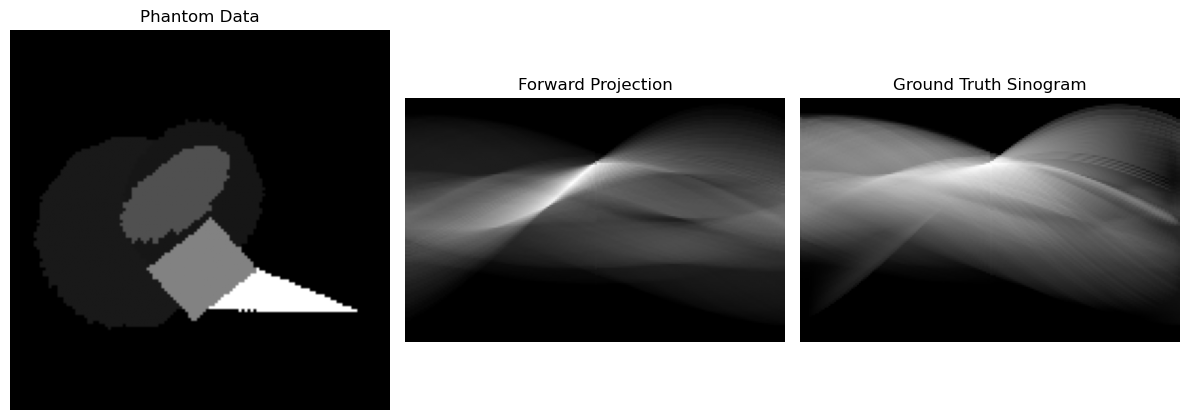

y_noisy shape: torch.Size([128, 200])


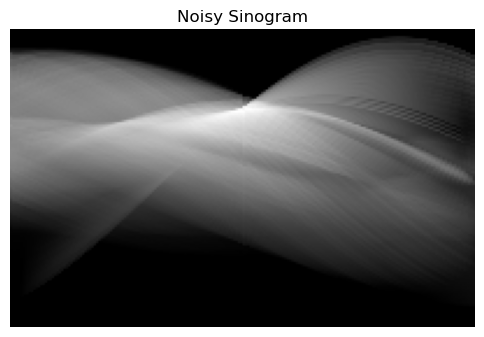

x_reconstructed shape: torch.Size([128, 128])


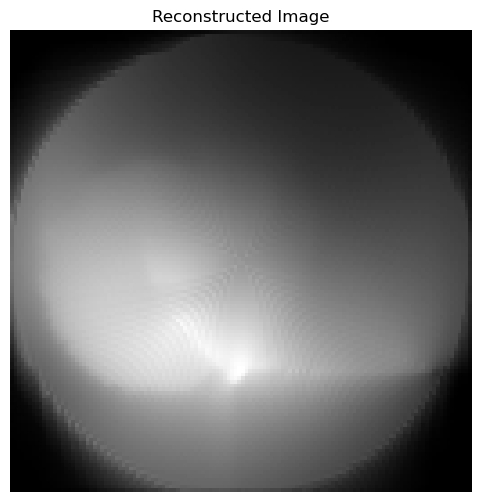

Min/Max of Phantom: 0.0/5.408486787622997e+24
Min/Max of Forward Projection: 0.0/1.2924849670525873e-06
Min/Max of Ground Truth Sinogram: 0.0/4.801265870092619e-08
Min/Max of Reconstructed Image: 0.0/9.546316641204758e-38
Sparsity of A_ut: 99.13%


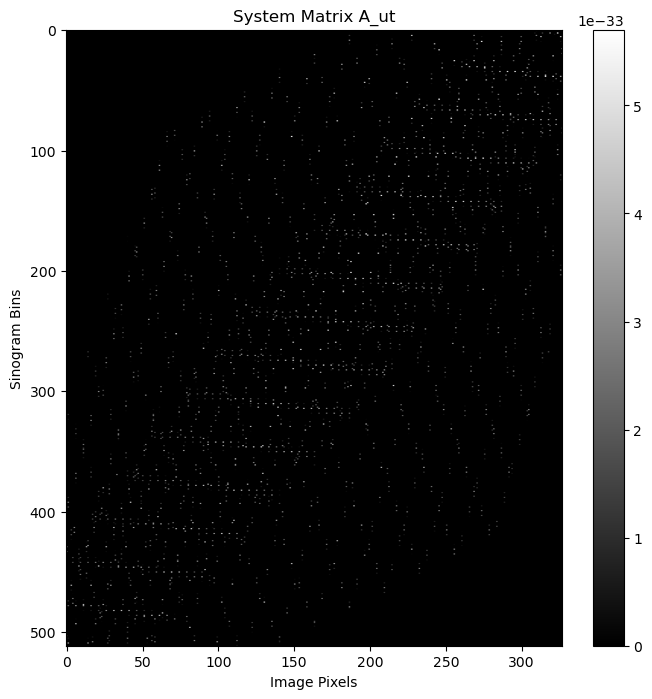

In [28]:
# Load the A_ut A_ub and A_tb matrices from the file and test them on forward projections of our phantom data

import numpy as np
import sys
import os
import matplotlib.pyplot as plt

import torch

data_folder: str = '../data_discretised/'

A_ut: np.ndarray | torch.Tensor = np.load(f'{data_folder}A_ut.npy')
#A_ub: np.ndarray | torch.Tensor = np.load(f'{data_folder}A_ub.npy')
#A_tb: np.ndarray | torch.Tensor = np.load(f'{data_folder}A_tb.npy')

A_ut = A_ut.astype(np.float32)
#A_ub = A_ub.astype(np.float32)
#A_tb = A_tb.astype(np.float32)

A_ut = torch.tensor(A_ut).cuda()  # Move to GPU if available
#A_ub = torch.tensor(A_ub).cuda()  # Move to GPU if available
#A_tb = torch.tensor(A_tb).cuda()  # Move to GPU if available

print(f'A_ut shape: {A_ut.shape}')
#print(f'A_ub shape: {A_ub.shape}')
#print(f'A_tb shape: {A_tb.shape}')

# Load the phantom data
x: np.ndarray | torch.Tensor = np.load(os.path.join(data_folder, 'phan-84.npy'))
x = torch.tensor(x).cuda()  # Move to GPU if available

gt_sino: np.ndarray | torch.Tensor = np.load(os.path.join(data_folder, 'sino-84.npy'))
gt_sino = torch.tensor(gt_sino).cuda()  # Move to GPU if available

print(f'x shape: {x.shape}')

# Forward projection
y: torch.Tensor = A_ut @ x[0].ravel() #np.sum(x, axis=0).ravel()

print(f'y shape: {y.shape}')
y = y.reshape((128, -1))
print(f'y reshaped to: {y.shape}')

print(f'{torch.sum(y - torch.sum(gt_sino, axis=-1)).item()}')

# Plot the Phantom Data, Forward projection, and Ground Truth Sinogram
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
plt.imshow(x[0].cpu().numpy(), cmap='gray')
plt.title('Phantom Data')
plt.axis('off')
plt.subplot(1, 3, 2)
plt.imshow(y.cpu().numpy(), cmap='gray')
plt.title('Forward Projection')
plt.axis('off')
plt.subplot(1, 3, 3)
plt.imshow(torch.sum(gt_sino, axis=-1).cpu().numpy(), cmap='gray')
plt.title('Ground Truth Sinogram')
plt.axis('off')
plt.tight_layout()
plt.show()


# A_ut_pinv: torch.Tensor = torch.tensor(np.load(f'{data_folder}A_ut_pinv.npy')).cuda()  # Load the pseudo-inverse of A_ut
# print(f'A_ut_pinv shape: {A_ut_pinv.shape}')

# Let's degrade the y sinogram with some noise
y_noisy = torch.sum(gt_sino, axis=-1).float().clone()
#y_noisy[69,69] = 0.0
#y_noisy: torch.Tensor = poisson_noise(y, noise_factor=0.1, clamp=True, scale=1e7)
#y_noisy = sino_undersample(y.unsqueeze(0).unsqueeze(0), mask_proportion=0.2).squeeze(0).squeeze(0)  # Undersample the noisy sinogram
print(f'y_noisy shape: {y_noisy.shape}')
# Plot the noisy sinogram
plt.figure(figsize=(6, 6))
plt.imshow(y_noisy.cpu().numpy(), cmap='gray')
plt.title('Noisy Sinogram')
plt.axis('off')
plt.show()


# Try applying the transpose of the matrix to the sinogram
x_reconstructed: torch.Tensor = A_ut.T @ y_noisy.ravel()
x_reconstructed = x_reconstructed.reshape((128, -1))
print(f'x_reconstructed shape: {x_reconstructed.shape}')
x_reconstructed = x_reconstructed.reshape(x[0].shape)
# Plot the reconstructed image
plt.figure(figsize=(6, 6))
plt.imshow(x_reconstructed.cpu().numpy(), cmap='gray')
plt.title('Reconstructed Image')
plt.axis('off')
plt.show()

# Print min and max vaues of original phantom, forward projection, original sinogram, and reconstructed image
print(f'Min/Max of Phantom: {torch.min(x[0])}/{torch.max(x[0])}')
print(f'Min/Max of Forward Projection: {torch.min(y)}/{torch.max(y)}')
print(f'Min/Max of Ground Truth Sinogram: {torch.min(gt_sino)}/{torch.max(gt_sino)}')
print(f'Min/Max of Reconstructed Image: {torch.min(x_reconstructed)}/{torch.max(x_reconstructed)}')

# Okay hear me out, let's visualise the entire system matrix A_ut
# first let's treat the matrix as a 2D image and scale it down to use less memory
A_ut_small: torch.Tensor = torch.nn.functional.interpolate(A_ut.unsqueeze(0).unsqueeze(0), size=(A_ut.size()[0]//50, A_ut.size()[1]//50), mode='bilinear', align_corners=False).squeeze(0).squeeze(0)
# Let's also print the sparsity percentage of the matrix
sparsity: float = 100.0 * torch.sum(A_ut == 0).item() / A_ut.numel()
print(f'Sparsity of A_ut: {sparsity:.2f}%')

plt.figure(figsize=(8, 8))
plt.imshow(A_ut_small.cpu().numpy(), cmap='gray', aspect='auto')
plt.title('System Matrix A_ut')
plt.xlabel('Image Pixels')
plt.ylabel('Sinogram Bins')
plt.colorbar()
plt.show()  


In [ ]:
# Let's try and apply SVD to our A_ut matrix

U, S, Vh = torch.linalg.svd(A_ut, full_matrices=False)

# Right singular vectors as columns
V: torch.Tensor = Vh.T


First 10 singular values of A_ut:
Singular value 1: 6.505084644936368e-31
Singular value 2: 4.390829220801634e-31
Singular value 3: 4.307412380085362e-31
Singular value 4: 3.6113622081555576e-31
Singular value 5: 3.5378924006359436e-31
Singular value 6: 3.524869804019794e-31
Singular value 7: 3.180651909158335e-31
Singular value 8: 3.109529093659573e-31
Singular value 9: 2.942808964981318e-31
Singular value 10: 2.918227732413533e-31


Min and max singular values of A_ut: 1.7713333813886523e-34/6.505084644936368e-31
First 10 singular values of A_ut:
Singular value 1: 6.505084644936368e-31
Singular value 2: 4.390829220801634e-31
Singular value 3: 4.307412380085362e-31
Singular value 4: 3.6113622081555576e-31
Singular value 5: 3.5378924006359436e-31
Singular value 6: 3.524869804019794e-31
Singular value 7: 3.180651909158335e-31
Singular value 8: 3.109529093659573e-31
Singular value 9: 2.942808964981318e-31
Singular value 10: 2.918227732413533e-31


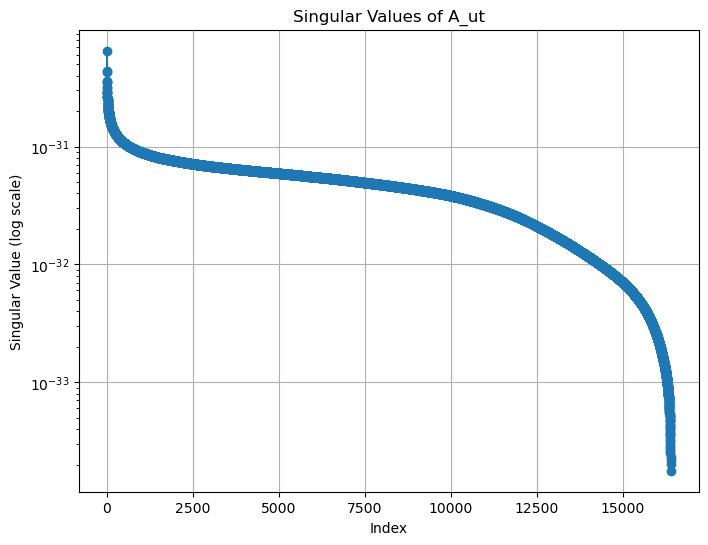

x_reconstructed shape: torch.Size([128, 128])


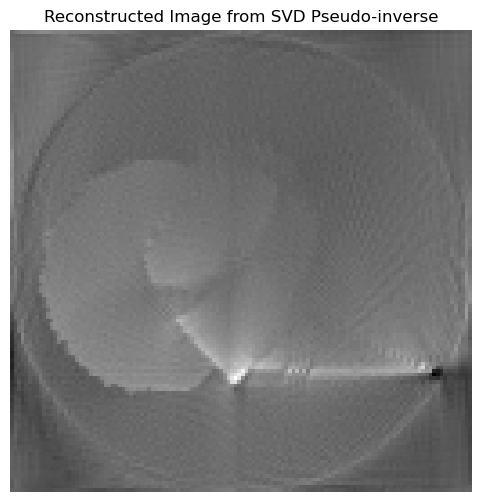

In [27]:
# Let's save our computed SVD components for later use
svd_folder: str = '../data_discretised/svd/'
#os.makedirs(svd_folder, exist_ok=True)
#np.save(f'{svd_folder}A_ut_U.npy', U.cpu().numpy())
#np.save(f'{svd_folder}A_ut_S.npy', S.cpu().numpy())
#np.save(f'{svd_folder}A_ut_V.npy', V.cpu().numpy()) 

# Let's print some of the singular values
print(f"Min and max singular values of A_ut: {S[-1].item()}/{S[0].item()}")
print("First 10 singular values of A_ut:")
for i in range(10):
    print(f'Singular value {i+1}: {S[i].item()}')
# Let's plot the singular values
plt.figure(figsize=(8, 6))
plt.semilogy(S.cpu().numpy(), marker='o')
plt.title('Singular Values of A_ut')
plt.xlabel('Index')
plt.ylabel('Singular Value (log scale)')
plt.grid()
plt.show()


# Build pseudo-inverse from SVD components (truncated to regularize)
sigma_thresh = 0.5e-31
mask = (S > sigma_thresh).float()
S_inv = torch.zeros_like(S)
S_inv[mask.bool()] = 1.0 / S[mask.bool()]

# Compute pseudo-inverse regularised A_ut_reg_pinv
A_ut_reg_pinv: torch.Tensor = V @ (S_inv.unsqueeze(1) * U.T)

# Let's try applying the pseudo-inverse to the noisy sinogram
x_reconstructed: torch.Tensor = A_ut_reg_pinv @ y_noisy.ravel()

x_reconstructed = x_reconstructed.reshape((128, -1))
print(f'x_reconstructed shape: {x_reconstructed.shape}')
x_reconstructed = x_reconstructed.reshape(x[0].shape)
# Plot the reconstructed image
plt.figure(figsize=(6, 6))
plt.imshow(x_reconstructed.cpu().numpy(), cmap='gray')
plt.title('Reconstructed Image from SVD Pseudo-inverse')
plt.axis('off')
plt.show()


In [ ]:
# Let's do a sweep over different sigma_thresh values
# (let's take every 100th singular value as a threshold)
sigma_thresh_values = [S[i].item() for i in range(0, len(S), 100)] + [0.0]  # Include 0.0 to see the effect of no regularization

reconstructions = []

for sigma_thresh in sigma_thresh_values:
    mask = (S > sigma_thresh).float()
    S_inv = torch.zeros_like(S)
    S_inv[mask.bool()] = 1.0 / S[mask.bool()]

    # Compute pseudo-inverse regularised A_ut_reg_pinv
    A_ut_reg_pinv: torch.Tensor = V @ (S_inv.unsqueeze(1) * U.T)

    # Apply the pseudo-inverse to the noisy sinogram
    x_reconstructed: torch.Tensor = A_ut_reg_pinv @ y_noisy.ravel()
    x_reconstructed = x_reconstructed.reshape(x[0].shape)

    reconstructions.append((sigma_thresh, x_reconstructed))



In [ ]:
# Let's visualise the parameter-swept regularised reconstructions, and also compute the PSNR, SSIM, and RMSE for each
# Plot the reconstructions for different sigma_thresh values
#num_plots = len(reconstructions)
#plt.figure(figsize=(15, 5 * ((num_plots + 2) // 3)))
#for i, (sigma_thresh, x_reconstructed) in enumerate(reconstructions):
#    plt.subplot((num_plots + 2) // 3, 3, i + 1)
#    plt.imshow(x_reconstructed.cpu().numpy(), cmap='gray')
#    plt.title(f'Reconstructed Image\nsigma_thresh={sigma_thresh:.2e}')
#    plt.axis('off')
#plt.tight_layout()
#plt.show()


from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error as mse

def losses(x_reconstructed: torch.Tensor, x_gt: torch.Tensor):
    x_reconstructed_np = x_reconstructed.cpu().numpy()
    x_gt_np = x_gt.cpu().numpy()

    # Normalise to [0, 1] range for fair comparison
    x_reconstructed_np = (x_reconstructed_np - x_reconstructed_np.min()) / (x_reconstructed_np.max() - x_reconstructed_np.min())
    x_gt_np = (x_gt_np - x_gt_np.min()) / (x_gt_np.max() - x_gt_np.min())

    psnr_value = psnr(x_gt_np, x_reconstructed_np, data_range=x_gt_np.max() - x_gt_np.min())
    ssim_value = ssim(x_gt_np, x_reconstructed_np, data_range=x_gt_np.max() - x_gt_np.min())
    rmse_value = np.sqrt(mse(x_gt_np, x_reconstructed_np))

    return psnr_value, ssim_value, rmse_value

# Compute and print PSNR, SSIM, and RMSE for each reconstruction
for sigma_thresh, x_reconstructed in reconstructions:
    psnr_value, ssim_value, rmse_value = losses(x_reconstructed, x[0])

    print(f'sigma_thresh={sigma_thresh:.2e} => PSNR: {psnr_value:.2f}, SSIM: {ssim_value:.4f}, RMSE: {rmse_value:.4f}')

# Let's compute the losses on our earlier A^T-based reconstruction as well
psnr_value, ssim_value, rmse_value = losses(x_reconstructed, x[0])
print(f'A^T Reconstruction => PSNR: {psnr_value:.2f}, SSIM: {ssim_value:.4f}, RMSE: {rmse_value:.4f}')

/tmp/ipykernel_2098643/3359840818.py:23: RuntimeWarning: invalid value encountered in divide
  x_reconstructed_np = (x_reconstructed_np - x_reconstructed_np.min()) / (x_reconstructed_np.max() - x_reconstructed_np.min())


sigma_thresh=6.51e-31 => PSNR: nan, SSIM: nan, RMSE: nan
sigma_thresh=1.62e-31 => PSNR: 11.10, SSIM: 0.0791, RMSE: 0.2786
sigma_thresh=1.36e-31 => PSNR: 11.03, SSIM: 0.0906, RMSE: 0.2807
sigma_thresh=1.22e-31 => PSNR: 11.26, SSIM: 0.0948, RMSE: 0.2735
sigma_thresh=1.13e-31 => PSNR: 11.43, SSIM: 0.1015, RMSE: 0.2682
sigma_thresh=1.07e-31 => PSNR: 11.56, SSIM: 0.1036, RMSE: 0.2643
sigma_thresh=1.02e-31 => PSNR: 11.18, SSIM: 0.1039, RMSE: 0.2761
sigma_thresh=9.78e-32 => PSNR: 10.88, SSIM: 0.1044, RMSE: 0.2857
sigma_thresh=9.44e-32 => PSNR: 10.85, SSIM: 0.1077, RMSE: 0.2867
sigma_thresh=9.17e-32 => PSNR: 10.75, SSIM: 0.1074, RMSE: 0.2901
sigma_thresh=8.94e-32 => PSNR: 10.86, SSIM: 0.1091, RMSE: 0.2864
sigma_thresh=8.73e-32 => PSNR: 11.10, SSIM: 0.1115, RMSE: 0.2787
sigma_thresh=8.55e-32 => PSNR: 11.33, SSIM: 0.1147, RMSE: 0.2712
sigma_thresh=8.37e-32 => PSNR: 11.67, SSIM: 0.1167, RMSE: 0.2609
sigma_thresh=8.20e-32 => PSNR: 11.81, SSIM: 0.1174, RMSE: 0.2568
sigma_thresh=8.06e-32 => PSNR: 11

: 

A_ut_pinv shape: torch.Size([16384, 25600])
Residual (MAE): 5.2114276786445404e+22
PSNR: 14.619484901428223
SSIM: 0.2316659688949585


/home/samnub/anaconda3/envs/lircst-iterecon/lib/python3.13/site-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `peak_signal_noise_ratio` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `peak_signal_noise_ratio` from `torchmetrics.image` instead.
  _future_warning(
/home/samnub/anaconda3/envs/lircst-iterecon/lib/python3.13/site-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `spectral_angle_mapper` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `spectral_angle_mapper` from `torchmetrics.image` instead.
  _future_warning(


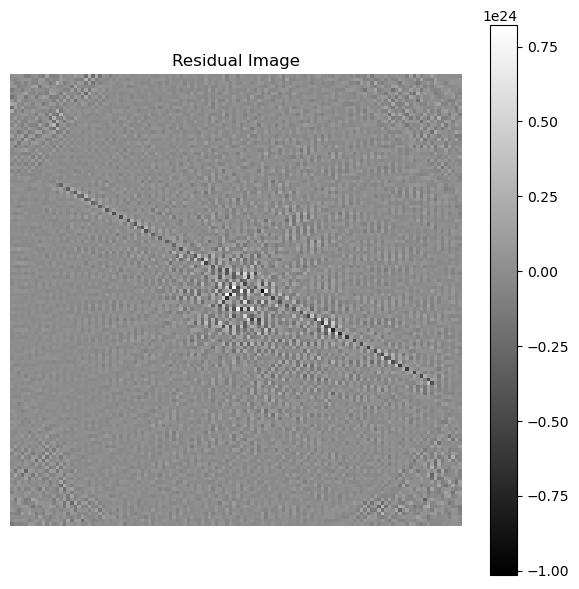

: 

In [ ]:
print(f'A_ut_pinv shape: {A_ut_pinv.shape}')

# Save the pinv matrix as numpy file
# np.save(f'{data_folder}A_ut_pinv.npy', A_ut_pinv.cpu().numpy())

# Let's compute the residual between x_reconstructed and the original phantom
residual: torch.Tensor = x_reconstructed - x[0]

print(f'Residual (MAE): {torch.mean(torch.abs(residual)).item()}')

# Let's also compute the PSNR and SSIM
import torchmetrics


x_reconstructed_scaled = x_reconstructed - torch.min(x_reconstructed)
x_reconstructed_scaled = x_reconstructed_scaled * (x_reconstructed_scaled.max() / x[0].max())

# Let's scale the images to [0, 1] for PSNR and SSIM calculation
x_reconstructed_scaled = (x_reconstructed_scaled - torch.min(x_reconstructed_scaled)) / (torch.max(x_reconstructed_scaled) - torch.min(x_reconstructed_scaled))
x_scaled = (x[0] - torch.min(x[0])) / (torch.max(x[0]) - torch.min(x[0]))

x_reconstructed_scaled = x_reconstructed_scaled.unsqueeze(0).unsqueeze(0)
x_scaled = x_scaled.unsqueeze(0).unsqueeze(0)

psnr = torchmetrics.functional.peak_signal_noise_ratio(x_reconstructed_scaled, x_scaled)
ssim = torchmetrics.functional.structural_similarity_index_measure(x_reconstructed_scaled, x_scaled)
print(f'PSNR: {psnr.item()}')
print(f'SSIM: {ssim.item()}')

# Plot the residual
plt.figure(figsize=(6, 6))
plt.imshow(residual.cpu().numpy(), cmap='gray')
plt.title('Residual Image')
plt.axis('off')
plt.colorbar()
plt.tight_layout()
plt.show()


Torch shape: torch.Size([400, 400])
Torch min/max: 0.0/1.0
Shepp shape: torch.Size([128, 128])
Shepp min/max: 0.0/1.0
Shepp de-normalised min/max: 0.0/5.952204785368368e+23
A_ut_shepp shape: torch.Size([25600, 16384])


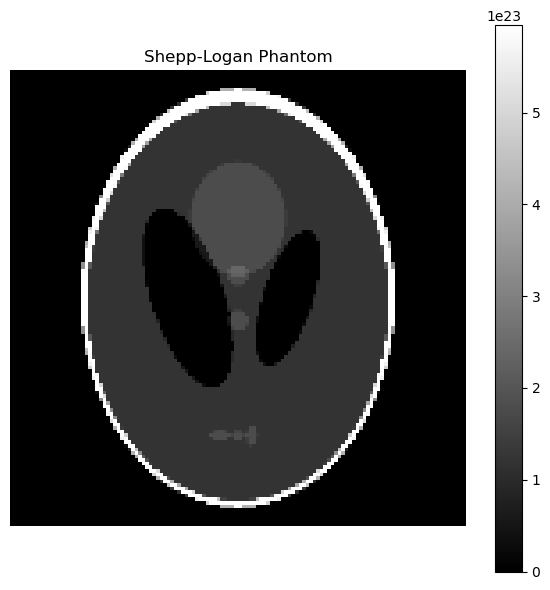

y_shepp shape: torch.Size([128, 200])


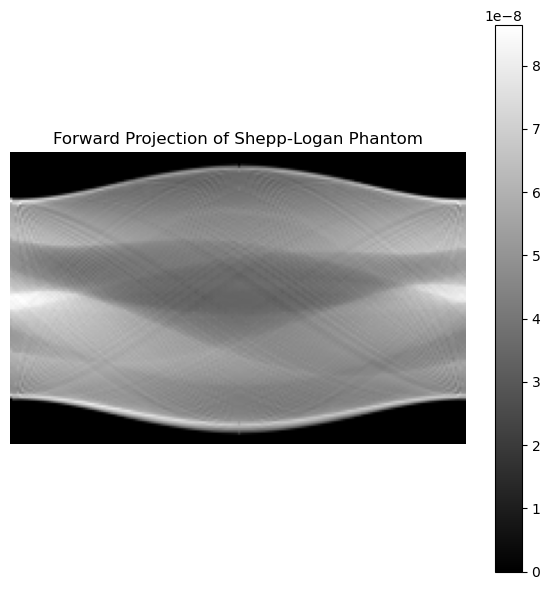

x_shepp shape: torch.Size([2, 128, 128])
x_shepp scat min/max: 0.0/5.952204785368368e+23
x_shepp attn min/max: 0.0/0.12606720626354218
y_shepp shape: torch.Size([128, 200, 1])


In [3]:
import numpy as np
import torch
import torch.nn.functional as F
from skimage.data import shepp_logan_phantom
import matplotlib.pyplot as plt

data_folder: str = '../data_discretised/'

shepp = torch.Tensor(shepp_logan_phantom()).cuda()  # Load the Shepp-Logan phantom and move to GPU if available


print(f'Torch shape: {shepp.shape}')
print(f'Torch min/max: {torch.min(shepp)}/{torch.max(shepp)}')

shepp = F.interpolate(shepp.unsqueeze(0).unsqueeze(0), size=(128, 128), mode='bilinear', align_corners=False).squeeze(0).squeeze(0)

print(f'Shepp shape: {shepp.shape}')
print(f'Shepp min/max: {torch.min(shepp)}/{torch.max(shepp)}')

shepp_unscaled = shepp.clone()  # Keep the unscaled version for reference

# If we have really attenuating materials, they'll block the x-rays quite a bit, so let's scale it down
scat_coeff_bone = 5.9522048782E+23 # The max value we'll use in our shepp logan phantom

phan0_min = 0.0
phan0_max = scat_coeff_bone

# De-normalise the Shepp phantom to match the range of the original phantom
shepp = shepp * (phan0_max - phan0_min) + phan0_min
print(f'Shepp de-normalised min/max: {torch.min(shepp)}/{torch.max(shepp)}')

# Load A_ut matrix to project the Shepp phantom into a sinogram
A_ut_shepp: np.ndarray | torch.Tensor = np.load(f'{data_folder}A_ut.npy')
A_ut_shepp = A_ut_shepp.astype(np.float32)
A_ut_shepp = torch.tensor(A_ut_shepp).cuda()  # Move to GPU if available
print(f'A_ut_shepp shape: {A_ut_shepp.shape}')

# Let's visualise the Shepp phantom
plt.figure(figsize=(6, 6))
plt.imshow(shepp.cpu().numpy(), cmap='gray')
plt.title('Shepp-Logan Phantom')
plt.axis('off')
plt.colorbar()
plt.tight_layout()
plt.show()

# Forward projection of the Shepp phantom
y_shepp: torch.Tensor = A_ut_shepp @ shepp.ravel()
y_shepp = y_shepp.reshape((128, -1))
print(f'y_shepp shape: {y_shepp.shape}')

# Let's visualise the forward projection of the Shepp phantom
plt.figure(figsize=(6, 6))
plt.imshow(y_shepp.cpu().numpy(), cmap='gray')
plt.title('Forward Projection of Shepp-Logan Phantom')
plt.axis('off')
plt.colorbar()
plt.tight_layout()
plt.show()

x_shepp: torch.Tensor = torch.zeros((2, 128, 128), dtype=torch.float32).cuda()  # Create a tensor for the Shepp phantom
x_shepp[0] = shepp  # Scatter channel
x_shepp[1] = shepp_unscaled  # Attenuation channel

atten_coeff_bone = 1.2606720000E-01

phan1_min = 0.0
phan1_max = atten_coeff_bone

# De-normalise attenuation channel
x_shepp[1] = x_shepp[1] * (phan1_max - phan1_min) + phan1_min

y_shepp = y_shepp.unsqueeze(-1) # Redundant bins channel for consistency with the original data format

print(f'x_shepp shape: {x_shepp.shape}')
print(f'x_shepp scat min/max: {torch.min(x_shepp[0])}/{torch.max(x_shepp[0])}')
print(f'x_shepp attn min/max: {torch.min(x_shepp[1])}/{torch.max(x_shepp[1])}')
print(f'y_shepp shape: {y_shepp.shape}')

# Save the Shepp phantom and its forward projection as numpy files
np.save(f'{data_folder}shepp_logan_phantom.npy', x_shepp.cpu().numpy())
np.save(f'{data_folder}shepp_logan_sinogram.npy', y_shepp.cpu().numpy())